In [1]:
import os

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import box

import osmnx as ox

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
crs_init='epsg:4326' ## WGS84
crs_out='epsg:26718' ## WGS 84 / UTM zone 18N

In [4]:
os.chdir(r'F:\OneDrive\Materials\GIS\practice\practice_5')

## Prepare end station data

In [5]:
df=pd.read_csv(r'202011-citibike-tripdata.csv')
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,521,2020-11-01 00:00:07.0150,2020-11-01 00:08:48.3010,3467,W Broadway & Spring St,40.724947,-74.001659,350,Clinton St & Grand St,40.715595,-73.987030,40405,Subscriber,1989,1
1,492,2020-11-01 00:00:10.8080,2020-11-01 00:08:23.3170,3557,40 Ave & 9 St,40.757420,-73.945133,3557,40 Ave & 9 St,40.757420,-73.945133,46504,Subscriber,1970,2
2,1979,2020-11-01 00:00:14.7040,2020-11-01 00:33:14.1640,3085,Roebling St & N 4 St,40.714690,-73.957390,3854,Morgan Ave & Maspeth Ave,40.716657,-73.936370,37452,Subscriber,1989,2
3,2382,2020-11-01 00:00:14.7070,2020-11-01 00:39:57.0030,3783,Cliff St & Fulton St,40.708380,-74.004950,3167,Amsterdam Ave & W 73 St,40.779668,-73.980930,40417,Subscriber,1981,1
4,166,2020-11-01 00:00:15.9690,2020-11-01 00:03:02.8980,422,W 59 St & 10 Ave,40.770513,-73.988038,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,35776,Subscriber,1990,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736699,257,2020-11-30 23:58:44.6840,2020-12-01 00:03:01.9470,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,421,Clermont Ave & Park Ave,40.695734,-73.971297,49932,Subscriber,1992,1
1736700,617,2020-11-30 23:58:45.6210,2020-12-01 00:09:02.8300,439,E 4 St & 2 Ave,40.726281,-73.989780,3709,W 15 St & 6 Ave,40.738046,-73.996430,38817,Customer,1969,0
1736701,116,2020-11-30 23:58:45.7200,2020-12-01 00:00:41.9570,3616,Steinway St & 28 Ave,40.765625,-73.913669,3600,31 Ave & Steinway St,40.761149,-73.917007,32874,Subscriber,1980,1
1736702,409,2020-11-30 23:59:20.1480,2020-12-01 00:06:09.7540,3521,Lenox Ave & W 111 St,40.798786,-73.952300,3325,E 95 St & 3 Ave,40.784903,-73.950503,36675,Customer,2001,1


In [6]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [7]:
endsta_cols=['end station id','end station name','end station latitude','end station longitude']

In [8]:
df_endsta=df.loc[:,endsta_cols]
df_endsta

,end station id,end station name,end station latitude,end station longitude
0,350,Clinton St & Grand St,40.715595,-73.987030
1,3557,40 Ave & 9 St,40.757420,-73.945133
2,3854,Morgan Ave & Maspeth Ave,40.716657,-73.936370
3,3167,Amsterdam Ave & W 73 St,40.779668,-73.980930
4,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886
...,...,...,...,...
1736699,421,Clermont Ave & Park Ave,40.695734,-73.971297
1736700,3709,W 15 St & 6 Ave,40.738046,-73.996430
1736701,3600,31 Ave & Steinway St,40.761149,-73.917007
1736702,3325,E 95 St & 3 Ave,40.784903,-73.950503


In [9]:
df_endsta_count=df_endsta.groupby('end station id',as_index=False)['end station id'].agg({"count":"count"})
df_endsta_count

,end station id,count
0,72,2989
1,79,1925
2,82,965
3,83,1588
4,119,504
...,...,...
1156,4230,27
1157,4232,1425
1158,4245,69
1159,4247,332


In [10]:
df_endsta_nodup=df_endsta.drop_duplicates(ignore_index=True)
df_endsta_nodup

,end station id,end station name,end station latitude,end station longitude
0,350,Clinton St & Grand St,40.715595,-73.987030
1,3557,40 Ave & 9 St,40.757420,-73.945133
2,3854,Morgan Ave & Maspeth Ave,40.716657,-73.936370
3,3167,Amsterdam Ave & W 73 St,40.779668,-73.980930
4,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886
...,...,...,...,...
1156,3639,Harborside,40.719252,-74.034234
1157,3203,Hamilton Park,40.727596,-74.044247
1158,4118,Liberty St & Nassau St,40.708589,-74.009355
1159,4219,W 35 St & 9 Ave,40.754145,-73.996089


In [11]:
df=pd.merge(df_endsta_count,df_endsta_nodup,on="end station id",)
df ## the dataset of all end stations with count of observations and without duplication

,end station id,count,end station name,end station latitude,end station longitude
0,72,2989,W 52 St & 11 Ave,40.767272,-73.993929
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667
2,82,965,St James Pl & Pearl St,40.711174,-74.000165
3,83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
4,119,504,Park Ave & St Edwards St,40.696089,-73.978034
...,...,...,...,...,...
1156,4230,27,Charlotte St & Boston Rd,40.835877,-73.893143
1157,4232,1425,6 Ave & W 45 St,40.756951,-73.982631
1158,4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546
1159,4247,332,Riverside Dr & W 153 St,40.832164,-73.949702


In [12]:
endPoints=gpd.points_from_xy(df['end station longitude'],df['end station latitude'])

In [13]:
gdf=gpd.GeoDataFrame(df,geometry=endPoints,crs=crs_init)
gdf ## geo dataset of end stations in WGS84

,end station id,count,end station name,end station latitude,end station longitude,geometry
0,72,2989,W 52 St & 11 Ave,40.767272,-73.993929,POINT (-73.99393 40.76727)
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,POINT (-74.00667 40.71912)
2,82,965,St James Pl & Pearl St,40.711174,-74.000165,POINT (-74.00017 40.71117)
3,83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,POINT (-73.97632 40.68383)
4,119,504,Park Ave & St Edwards St,40.696089,-73.978034,POINT (-73.97803 40.69609)
...,...,...,...,...,...,...
1156,4230,27,Charlotte St & Boston Rd,40.835877,-73.893143,POINT (-73.89314 40.83588)
1157,4232,1425,6 Ave & W 45 St,40.756951,-73.982631,POINT (-73.98263 40.75695)
1158,4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546,POINT (-73.88855 40.82195)
1159,4247,332,Riverside Dr & W 153 St,40.832164,-73.949702,POINT (-73.94970 40.83216)


In [14]:
data=gdf.to_crs(crs_out) ## geo dataset of end stations in WGS 84 / UTM zone 18N

## Create buffers around end stations

In [15]:
## calculate the distance to the nearest end station to each end station
for index, row in data.iterrows():
    point=row['geometry']
    multiPoint=data['geometry'].drop(index,axis=0).unary_union ## the multiPoint consistent of all the other end stations
    queried_geom,nearest_geom=nearest_points(point,multiPoint)
    data.loc[index,'nearest_dist']=queried_geom.distance(nearest_geom)
data

,end station id,count,end station name,end station latitude,end station longitude,geometry,nearest_dist
0,72,2989,W 52 St & 11 Ave,40.767272,-73.993929,POINT (584879.130 4513194.532),286.714750
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,POINT (583864.569 4507836.699),195.725690
2,82,965,St James Pl & Pearl St,40.711174,-74.000165,POINT (584423.678 4506961.417),253.439914
3,83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,POINT (586472.928 4503948.899),192.186525
4,119,504,Park Ave & St Edwards St,40.696089,-73.978034,POINT (586312.530 4505308.486),324.067834
...,...,...,...,...,...,...,...
1156,4230,27,Charlotte St & Boston Rd,40.835877,-73.893143,POINT (593289.075 4520912.520),179.544689
1157,4232,1425,6 Ave & W 45 St,40.756951,-73.982631,POINT (585845.914 4512059.835),29.007284
1158,4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546,POINT (593696.234 4519371.657),154.287297
1159,4247,332,Riverside Dr & W 153 St,40.832164,-73.949702,POINT (588525.484 4520441.633),272.420308


In [16]:
data['nearest_dist'].describe()

count    1161.000000
mean      224.046127
std        82.454920
min        12.086323
25%       175.788359
50%       219.020330
75%       259.097633
max       825.997839
Name: nearest_dist, dtype: float64

In [17]:
data['nearest_dist'].median()

219.02032972591738

In [18]:
buffer_dist=data['nearest_dist'].mean().round(-2)/2
buffer_dist ## use 100 meters as the radius of the buffer

100.0

In [19]:
endsta_buffer=data['geometry'].buffer(buffer_dist)
endsta_buffer

0       POLYGON ((584979.130 4513194.532, 584978.648 4...
1       POLYGON ((583964.569 4507836.699, 583964.088 4...
2       POLYGON ((584523.678 4506961.417, 584523.197 4...
3       POLYGON ((586572.928 4503948.899, 586572.446 4...
4       POLYGON ((586412.530 4505308.486, 586412.049 4...
                              ...                        
1156    POLYGON ((593389.075 4520912.520, 593388.594 4...
1157    POLYGON ((585945.914 4512059.835, 585945.432 4...
1158    POLYGON ((593796.234 4519371.657, 593795.752 4...
1159    POLYGON ((588625.484 4520441.633, 588625.003 4...
1160    POLYGON ((592194.930 4520931.060, 592194.449 4...
Length: 1161, dtype: geometry

In [20]:
endsta_buffer.name="geometry"

In [21]:
data_buffer=gpd.GeoDataFrame(endsta_buffer).merge(data.drop(['geometry','nearest_dist'],axis=1),
                                                  left_index=True,right_index=True)

Note that one geo dataframe can only has one geometry, so we remove the old geometry for points of end points before merge the new geometry of buffers.

In [22]:
data_buffer

,geometry,end station id,count,end station name,end station latitude,end station longitude
0,"POLYGON ((584979.130 4513194.532, 584978.648 4...",72,2989,W 52 St & 11 Ave,40.767272,-73.993929
1,"POLYGON ((583964.569 4507836.699, 583964.088 4...",79,1925,Franklin St & W Broadway,40.719116,-74.006667
2,"POLYGON ((584523.678 4506961.417, 584523.197 4...",82,965,St James Pl & Pearl St,40.711174,-74.000165
3,"POLYGON ((586572.928 4503948.899, 586572.446 4...",83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
4,"POLYGON ((586412.530 4505308.486, 586412.049 4...",119,504,Park Ave & St Edwards St,40.696089,-73.978034
...,...,...,...,...,...,...
1156,"POLYGON ((593389.075 4520912.520, 593388.594 4...",4230,27,Charlotte St & Boston Rd,40.835877,-73.893143
1157,"POLYGON ((585945.914 4512059.835, 585945.432 4...",4232,1425,6 Ave & W 45 St,40.756951,-73.982631
1158,"POLYGON ((593796.234 4519371.657, 593795.752 4...",4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546
1159,"POLYGON ((588625.484 4520441.633, 588625.003 4...",4247,332,Riverside Dr & W 153 St,40.832164,-73.949702


## Retrieve restaurant data from Open Street Map

In [23]:
west, south, east, north=bbox=gdf.total_bounds 
bbox

array([-74.07106072,  40.65539977, -73.884308  ,  40.852252  ])

Note that the geometric information of bbox must in longitude and latitude degrees

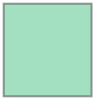

In [24]:
poly=box(west, south, east, north, ccw=True)
poly

In [25]:
restaurants=ox.geometries.geometries_from_polygon(poly,{"amenity":"restaurant"})

In [26]:
restaurants.crs 

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The initial data retrieved from OSM is in latitude and longtitude degree, so it is impossible to decide whether a certain restaurant is within the **100-meter buffer** of a certain end station. We need to project the restaurant data.

In [27]:
resta_data=restaurants.to_crs(crs_out) ## Project restaurant data to the same CRS as the end station data

In [28]:
resta_data

,unique_id,osmid,element_type,amenity,name,wikidata,geometry,addr:city,addr:housenumber,addr:street,...,building:use,max_level,min_level,ways,type,biergarten,gnis:county_name,gnis:feature_id,gnis:import_uuid,gnis:reviewed
0,node/296568074,296568074,node,restaurant,The Brass Rail,Q7719863,POINT (581840.557 4509976.822),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/305499273,305499273,node,restaurant,Court Street,NaN,POINT (581983.888 4510502.531),Hoboken,61,6th St,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/357620442,357620442,node,restaurant,Dolcino Trattoria Toscana,NaN,POINT (586217.632 4510355.192),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/380044344,380044344,node,restaurant,Pedro's,NaN,POINT (585583.515 4506015.236),Brooklyn,73,Jay Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/419359942,419359942,node,restaurant,Boutros,NaN,POINT (585014.646 4504636.194),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,way/903964406,903964406,way,restaurant,Mok Bar,NaN,"POLYGON ((586537.358 4503660.289, 586538.808 4...",NaN,212,Flatbush Avenue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4498,way/905435932,905435932,way,restaurant,Pier 66 Maritime Bar and Grill,NaN,"POLYGON ((583561.996 4511526.297, 583536.347 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4499,way/923404957,923404957,way,restaurant,G&J's Pizzeria,NaN,"POLYGON ((588891.347 4515802.526, 588887.764 4...",New York,188,East 104th Street,...,retail,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4500,relation/3698871,3698871,relation,restaurant,Loeb Boathouse,NaN,"POLYGON ((587005.266 4514133.915, 587010.366 4...",New York,NaN,NaN,...,NaN,NaN,NaN,"[278361408, 278361409]",multipolygon,NaN,NaN,NaN,NaN,NaN


In [29]:
cols = ['osmid','name', 'addr:street','geometry']
resta_data=resta_data.loc[:,cols]

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Spatial Join restaurant data with end station data

In [30]:
data_sjoin=gpd.sjoin(data_buffer,resta_data).drop(["geometry","index_right"],axis=1)
data_sjoin

,end station id,count,end station name,end station latitude,end station longitude,osmid,name,addr:street
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,2897876741,Square Diner,Leonard Street
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,5593041648,NaN,Franklin Street
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,4848257932,Distilled,West Broadway
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,4848258525,Terra,NaN
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,2892641901,Butterfly,NaN
...,...,...,...,...,...,...,...,...
1081,4137,233,3 Ave & E 163 St,40.823872,-73.908699,5549670841,Linda's Pizzeria,3rd Avenue
1119,4179,138,Freeman St & Southern Blvd,40.830051,-73.892103,5565399354,Luke's Pizza,Southern Boulevard
1126,4188,358,Broadway & W 155 St,40.832990,-73.945920,3627346237,La Libertad,NaN
1149,4219,272,W 35 St & 9 Ave,40.754145,-73.996089,3809000940,Lizette Restaurant,NaN


In [31]:
resta_count=data_sjoin.groupby('end station id',as_index=False)['osmid'].agg({"resta_count":"count"})
resta_count

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,end station id,resta_count
0,79,7
1,82,1
2,120,1
3,127,2
4,128,6
...,...,...
513,4120,13
514,4137,1
515,4179,1
516,4188,1


In [32]:
data_final=data.merge(resta_count,on="end station id",how="left")
data_final

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,end station id,count,end station name,end station latitude,end station longitude,geometry,nearest_dist,resta_count
0,72,2989,W 52 St & 11 Ave,40.767272,-73.993929,POINT (584879.130 4513194.532),286.714750,NaN
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,POINT (583864.569 4507836.699),195.725690,7.0
2,82,965,St James Pl & Pearl St,40.711174,-74.000165,POINT (584423.678 4506961.417),253.439914,1.0
3,83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,POINT (586472.928 4503948.899),192.186525,NaN
4,119,504,Park Ave & St Edwards St,40.696089,-73.978034,POINT (586312.530 4505308.486),324.067834,NaN
...,...,...,...,...,...,...,...,...
1156,4230,27,Charlotte St & Boston Rd,40.835877,-73.893143,POINT (593289.075 4520912.520),179.544689,NaN
1157,4232,1425,6 Ave & W 45 St,40.756951,-73.982631,POINT (585845.914 4512059.835),29.007284,NaN
1158,4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546,POINT (593696.234 4519371.657),154.287297,NaN
1159,4247,332,Riverside Dr & W 153 St,40.832164,-73.949702,POINT (588525.484 4520441.633),272.420308,NaN


In [33]:
data_final['resta_count']=data_final['resta_count'].fillna(0).astype(int)

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data_final

,end station id,count,end station name,end station latitude,end station longitude,geometry,nearest_dist,resta_count
0,72,2989,W 52 St & 11 Ave,40.767272,-73.993929,POINT (584879.130 4513194.532),286.714750,0
1,79,1925,Franklin St & W Broadway,40.719116,-74.006667,POINT (583864.569 4507836.699),195.725690,7
2,82,965,St James Pl & Pearl St,40.711174,-74.000165,POINT (584423.678 4506961.417),253.439914,1
3,83,1588,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,POINT (586472.928 4503948.899),192.186525,0
4,119,504,Park Ave & St Edwards St,40.696089,-73.978034,POINT (586312.530 4505308.486),324.067834,0
...,...,...,...,...,...,...,...,...
1156,4230,27,Charlotte St & Boston Rd,40.835877,-73.893143,POINT (593289.075 4520912.520),179.544689,0
1157,4232,1425,6 Ave & W 45 St,40.756951,-73.982631,POINT (585845.914 4512059.835),29.007284,0
1158,4245,69,Bruckner Blvd & Bryant Ave,40.821952,-73.888546,POINT (593696.234 4519371.657),154.287297,0
1159,4247,332,Riverside Dr & W 153 St,40.832164,-73.949702,POINT (588525.484 4520441.633),272.420308,0


In [35]:
data_final["resta_count"].describe()

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    1161.00000
mean        1.40913
std         2.43301
min         0.00000
25%         0.00000
50%         0.00000
75%         2.00000
max        18.00000
Name: resta_count, dtype: float64

In [36]:
data_final["resta_count"].value_counts()

0     643
1     195
2      87
3      73
5      41
4      40
6      27
7      16
8      12
9       7
12      6
10      4
13      4
11      2
14      1
15      1
17      1
18      1
Name: resta_count, dtype: int64

In [37]:
data_final_fp=r"end_stations_#restaurant.shp.shp"
data_final.to_file(data_final_fp)

## Prepare NYC district base map

In [38]:
nycfp=r"nyad_21a\nyad.shp"
nyc=gpd.read_file(nycfp)

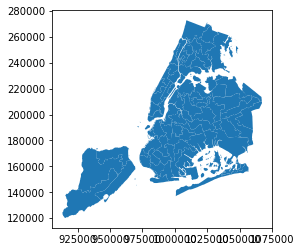

In [39]:
nyc.plot()

In [40]:
nyc.crs

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [41]:
nyc=nyc.to_crs(crs_out)

## Create Final Plot

In [42]:
def category(x):
    if x<=5:
        y=f"{{}}".format(x)
    else:
        y="6-18"
    return y

In [43]:
data_final["resta_count_cat"]=data_final["resta_count"].apply(category)

In [45]:
cmap=cm.get_cmap("viridis_r") ## set cmap

In [46]:
west, south, east, north=bbox=data_final.total_bounds 
poly=box(west, south, east, north, ccw=True)
xlim=(west,east)
ylim=(south,north)  ## set the limits on x and y axes

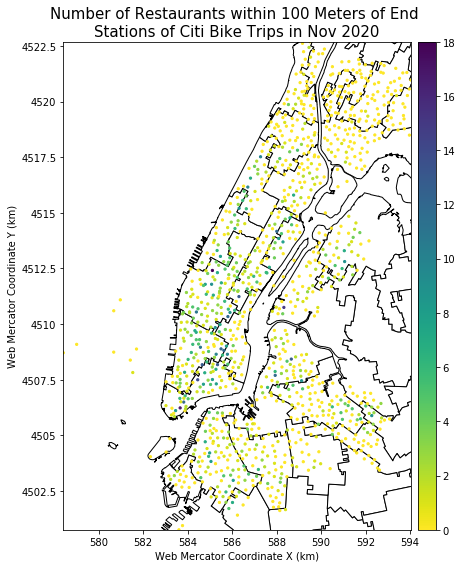

In [47]:
fig,ax=plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

nyc.plot(ax=ax,color="white",edgecolor="black",linewidth=1)

divider=make_axes_locatable(ax)
cax=divider.append_axes("right",size="5%",pad=0.1)
data_final.plot(ax=ax,column="resta_count",cmap=cmap,cax=cax,markersize=5,legend=True)

ax.set_title("Number of Restaurants within 100 Meters of End \nStations of Citi Bike Trips in Nov 2020",size=15)
ax.set_xlabel("Web Mercator Coordinate X (km)")
ax.set_ylabel("Web Mercator Coordinate Y (km)")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.ticklabel_format(useOffset=False,style='plain')

scale_x = 1e3
scale_y = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.tight_layout()

outfp="endsta_resta_count_nov2020_colorbar.png"
plt.savefig(outfp,dpi=300)

Because the number of nearby restaurants does not follow a uniform distribution (it is highly right skewed), the figure above is not very comprehensible. A better way is to categorize the count of nearby restaurant so that the large values that occur rarely are treated as one single category. 

D:\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


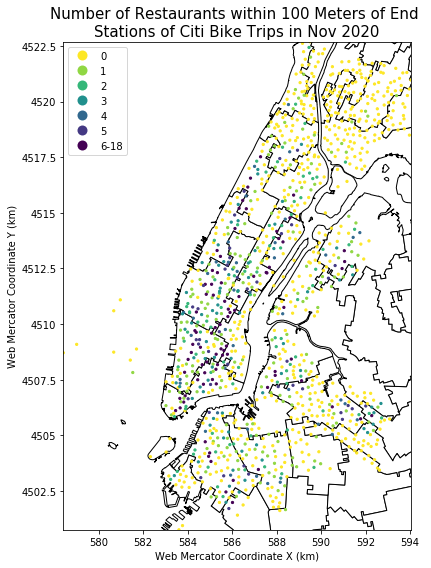

In [48]:
fig,ax=plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

nyc.plot(ax=ax,color="white",edgecolor="black",linewidth=1)

data_final.plot(ax=ax,column="resta_count_cat",cmap=cmap,
                categorical=True,markersize=5,legend=True)

ax.set_title("Number of Restaurants within 100 Meters of End \nStations of Citi Bike Trips in Nov 2020",size=15)
ax.set_xlabel("Web Mercator Coordinate X (km)")
ax.set_ylabel("Web Mercator Coordinate Y (km)")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.ticklabel_format(useOffset=False,style='plain')

scale_x = 1e3
scale_y = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.tight_layout()

outfp="endsta_resta_count_nov2020_category.png"
plt.savefig(outfp,dpi=300)